In [1]:
import tensorflow as tf
import numpy as np
from keras.utils import np_utils
import os
import onnxruntime as ort

#  visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

2023-06-05 09:15:58.541507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 09:15:58.592763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 09:15:58.593496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 09:15:59.497071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def create_and_train_mnist():
    """create and train a CNN model on the MNSIT dataset

    Returns:
        model: the trained CNN
    """
    # import and scale data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32")/255
    x_test  = x_test.astype("float32")/255
    num_classes = 10
    input_shape = (28, 28, 1)

    # one-hot encoding
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)


    # create the model
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=input_shape),
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.summary()

    # train the model 
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    batch_size = 128
    epochs = 3
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test)
    )

    # evaluate the model 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    return model



In [7]:
def compare_tf_onnx_results(sample, sess, tf_model, x_test, y_test) -> None:
    """Compare prediction results of train tf and converted onnx model

    Args:
        sample (int): sample index in test set
        sess (): onnx runtime session to evaluate model
        tf_model (saved_model): trained tf model
        x_test (np.array): test data set input
        y_test (np.array): test data set output
    """
    image = x_test[sample]
    fig = plt.figure
    plt.imshow(image, cmap="gray")
    plt.show()
    print("The true output is ", str(y_test[sample]))

    # preprocessing
    input_image = image.reshape(1, 28,28,1).astype("float32")/255

    # tensorflow model
    results_tf = tf_model(input_image)

    # onnx model
    input_name = sess.get_inputs()[0].name
    results_ort = sess.run(None, {input_name: input_image})[0]

    # compare output
    for ort_res, tf_res in zip(results_ort, results_tf):
        np.testing.assert_allclose(ort_res, tf_res, rtol=1e-5, atol=1e-5)

    print("Predicted output is", np.argmax(results_tf))
    print("Results match for predicted output vectors.")

    # sns.barplot(x=np.arange(0,10), y=np.array(results_tf).flatten())

In [4]:
"""
Create and export tf model in the format "saved_model"
"""
trained_model = create_and_train_mnist()
save_dir = "tf_mnist"
tf.saved_model.save(trained_model, save_dir)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

2023-06-05 09:17:02.455374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1600]
	 [[{{node inputs}}]]
2023-06-05 09:17:02.655178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1600]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: tf_mnist/assets


INFO:tensorflow:Assets written to: tf_mnist/assets


In [5]:
"""
convert to onnx system
"""
# use cli, for more complicated models specify input and output signatures
# if it fails, adapt opset to newer version
# https://github.com/onnx/tensorflow-onnx#cli-reference
!python -m tf2onnx.convert --saved-model ./tf_mnist/ --output ./tf_mnist/mnist.onnx --opset 15

2023-06-05 09:17:04.730397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-05 09:17:05,898 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-06-05 09:17:06,131 - INFO - Signatures found in model: [serving_default].
2023-06-05 09:17:06,131 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-06-05 09:17:06,131 - INFO - Output names: ['dense']
2023-06-05 09:17:06,235 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.14.0/8f8d49
2023-06-05 09:17:06,235 - INFO - Using opset <onnx, 15>
2023-06-05 09:17:06,242 - INFO - Computed 0 values for constant folding
2023-06-05 09:17:06,264 - INFO - Optimizing ONNX model
2023-06-05 09:17:06,315 

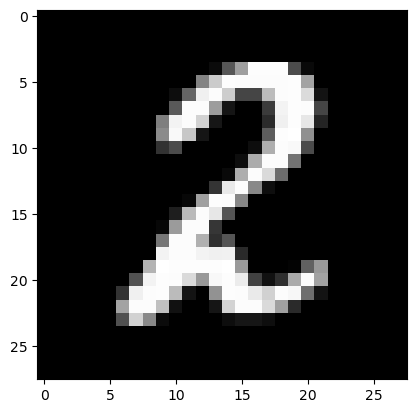

The true output is  2
Predicted output is 2
Results match for predicted output vectors.


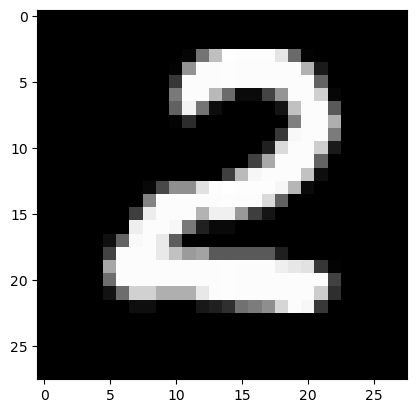

The true output is  2
Predicted output is 2
Results match for predicted output vectors.


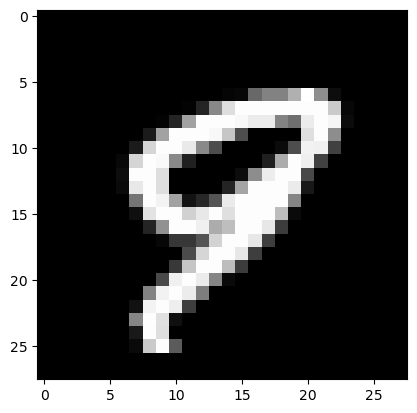

The true output is  9
Predicted output is 9
Results match for predicted output vectors.


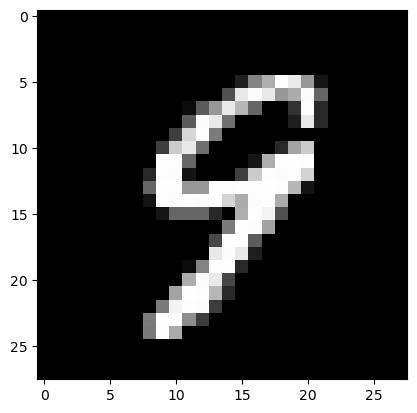

The true output is  9
Predicted output is 9
Results match for predicted output vectors.


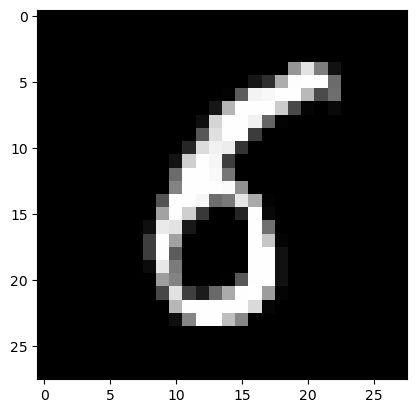

The true output is  6
Predicted output is 6
Results match for predicted output vectors.


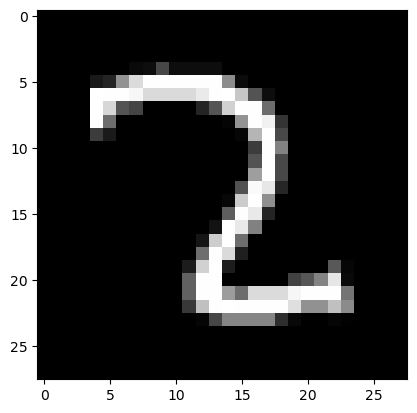

The true output is  2
Predicted output is 2
Results match for predicted output vectors.


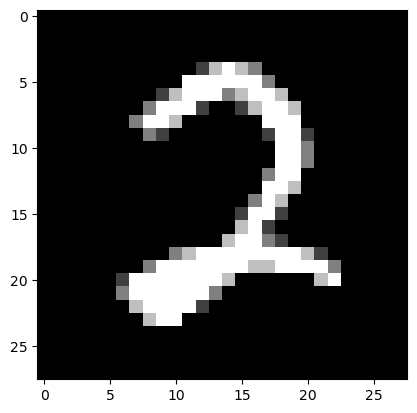

The true output is  2
Predicted output is 2
Results match for predicted output vectors.


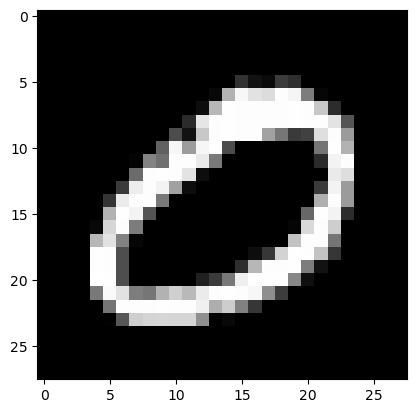

The true output is  0
Predicted output is 0
Results match for predicted output vectors.


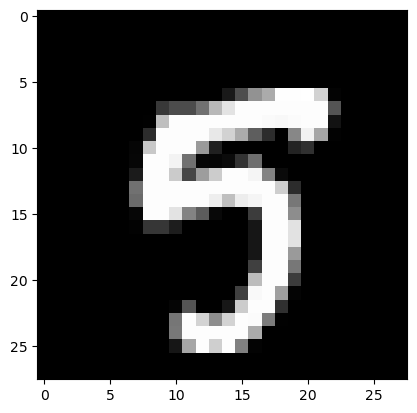

The true output is  5
Predicted output is 5
Results match for predicted output vectors.


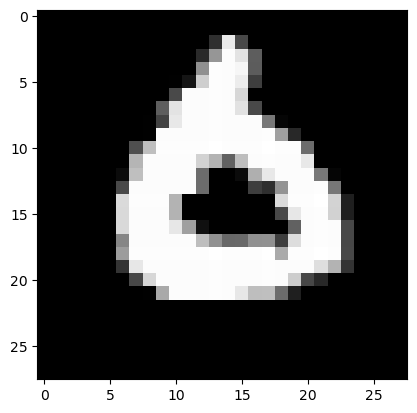

The true output is  6
Predicted output is 0
Results match for predicted output vectors.


In [8]:
""" 
verify conversion with onnxruntime
assert prediced output vectors of 10 different test images
https://onnxruntime.ai/docs/tutorials/tf-get-started.html
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
n_testimages = len(y_test)
samples = np.random.randint(0, n_testimages,size=10) 

tf_model = tf.saved_model.load("./tf_mnist/")

sess = ort.InferenceSession("./tf_mnist/mnist.onnx", providers=ort.get_available_providers())

for sample in samples:
    compare_tf_onnx_results(sample, sess, tf_model, x_test, y_test)